<a href="https://colab.research.google.com/github/TangriDhruv/Deepfake-detection-Using-NAS/blob/radprk-nasppo-notebook-1/nas_rl_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install kaggle
!pip install kaggle

# Set up kaggle credentials
!mkdir -p ~/.kaggle
!echo '{"username":"radhaparikh","key":"15203d4d89dd3bfbfd810d973eecda94"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset - FIXED LINE BELOW
!kaggle datasets download -d dhruvtangri1998/asvspoof-dataset-2019

# Unzip the downloaded dataset
!unzip asvspoof-dataset-2019.zip

# Remove the zip file (optional)
!rm asvspoof-dataset-2019.zip

Dataset URL: https://www.kaggle.com/datasets/dhruvtangri1998/asvspoof-dataset-2019
License(s): unknown
100% 7.12G/7.12G [04:17<00:00, 32.5MB/s]
100% 7.12G/7.12G [04:17<00:00, 29.7MB/s]
Archive:  asvspoof-dataset-2019.zip
replace LA/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.dev.female.trl.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace LA/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.dev.female.trn.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def extract_log_mel(audio_path, n_mels=128):
    audio, sr = librosa.load(audio_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel_spec)
    return log_mel

In [ ]:
def extract_cqt(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    cqt = librosa.cqt(y=audio, sr=sr)
    cqt_mag = np.abs(cqt)
    return librosa.amplitude_to_db(cqt_mag)

In [ ]:
import numpy as np
import torch
import torch.utils.data as data
import librosa
import os
from pathlib import Path

class ASVspoofDataset(data.Dataset):
    def __init__(self, root_dir, partition, protocol_name, feature_type='raw', is_rand=False):
        """
        Args:
            root_dir: Root directory of the ASVspoof dataset
            partition: 'train', 'dev', or 'eval'
            protocol_name: Name of the protocol file
            feature_type: Type of features to extract ('raw', 'mfcc', 'mel')
            is_rand: Whether to randomly select a portion of audio
        """
        super(ASVspoofDataset, self).__init__()
        self.root_dir = Path(root_dir)
        self.partition = partition
        self.feature_type = feature_type
        self.is_rand = is_rand

        # Map system IDs to numeric labels
        self.sysid_dict = {
            'bonafide': 1,  # bonafide speech
            'spoof': 0,     # Spoofed signal
        }

        # Set the protocol file path
        protocol_path = self.root_dir / protocol_name
        print('Reading', protocol_path)
        if self.is_rand:
            print('Using randomly selected sequence')

        # Read protocol file
        if not os.path.exists(protocol_path):
            raise FileNotFoundError(f"Protocol file {protocol_path} not found")
        protocol_lines = open(protocol_path).readlines()

        # Initialize features list
        self.features = []

        # Set the audio directory based on partition
        if self.partition == 'train':
            feature_address = 'ASVspoof2019_LA_train'
        elif self.partition == 'dev':
            feature_address = 'ASVspoof2019_LA_dev'
        elif self.partition == 'eval':
            feature_address = 'ASVspoof2019_LA_eval'
        else:
            raise ValueError(f"Invalid partition: {self.partition}")

        # Process each line in the protocol file
        for protocol_line in protocol_lines:
            tokens = protocol_line.strip().split(' ')
            # The protocols look like this:
            #  [0]      [1]       [2]     [3]    [4]
            # LA_0070 LA_D_7622198 -      -     bonafide
            #    -      file_name  -  attack_id  sys_id

            if len(tokens) < 5:
                print(f"Skipping malformed line: {protocol_line}")
                continue

            file_name = tokens[1]
            attack_id = tokens[3] if len(tokens) > 3 else '-'

            # Construct the full path to the audio file
            feature_path = self.root_dir / feature_address / (file_name + '.flac')

            # If the path doesn't exist, try with a 'flac' subdirectory
            if not os.path.exists(feature_path):
                feature_path = self.root_dir / feature_address / 'flac' / (file_name + '.flac')

                # If it still doesn't exist, raise an error
                if not os.path.exists(feature_path):
                    print(f"Warning: File {feature_path} not found, skipping")
                    continue

            try:
                sys_id = self.sysid_dict[tokens[4]]
            except KeyError:
                print(f"Skipping line with unknown system ID: {tokens[4]}")
                continue

            self.features.append((feature_path, file_name, attack_id, sys_id))

    def load_feature(self, feature_path):
        """Load audio and apply preprocessing"""
        try:
            # Load audio file
            feature, sr = librosa.load(feature_path, sr=16000)

            # Fixed length in samples (4 seconds)
            fix_len = sr * 4

            # Handle short audio by concatenating with itself
            REPEATED = False
            while feature.shape[0] < fix_len:
                feature = np.concatenate((feature, feature))
                REPEATED = True

            # Either randomly select a portion or take from the beginning
            if self.is_rand and not REPEATED:
                total_length = feature.shape[0]
                start = np.random.randint(0, total_length - fix_len + 1)
                feature = feature[start:start+fix_len]
            else:
                feature = feature[:fix_len]

            # Process features based on feature type
            if self.feature_type == 'mfcc':
                feature = librosa.feature.mfcc(y=feature, sr=sr, n_mfcc=20)
                # Transpose to have time as first dimension
                feature = feature.T
            elif self.feature_type == 'mel':
                feature = librosa.feature.melspectrogram(y=feature, sr=sr)
                feature = librosa.power_to_db(feature)
                # Transpose to have time as first dimension
                feature = feature.T

            return feature

        except Exception as e:
            print(f"Error loading {feature_path}: {e}")
            # Return zeros if loading fails
            if self.feature_type == 'mfcc':
                return np.zeros((20, sr * 4 // 512 + 1)).T
            elif self.feature_type == 'mel':
                return np.zeros((128, sr * 4 // 512 + 1)).T
            else:
                return np.zeros(sr * 4)

    def __getitem__(self, index):
        """Return a single data item by index"""
        feature_path, file_name, attack_id, sys_id = self.features[index]
        feature = self.load_feature(feature_path)
        return feature, file_name, attack_id, sys_id

    def __len__(self):
        """Return the number of items in the dataset"""
        return len(self.features)

In [ ]:
def get_asvspoof_loaders(root_dir, batch_size=32, num_workers=2, is_rand=False):
    """
    Create data loaders for ASVspoof dataset

    Args:
        root_dir: Root directory of the ASVspoof dataset
        batch_size: Batch size for DataLoader
        num_workers: Number of workers for DataLoader
        is_rand: Whether to randomly select a portion of audio

    Returns:
        train_loader, dev_loader, eval_loader
    """
    # Define protocol file paths
    train_protocol = 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
    dev_protocol = 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
    eval_protocol = 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'

    # Create datasets
    train_dataset = ASVspoofDataset(root_dir, 'train', train_protocol, is_rand=is_rand)
    dev_dataset = ASVspoofDataset(root_dir, 'dev', dev_protocol, is_rand=False)
    eval_dataset = ASVspoofDataset(root_dir, 'eval', eval_protocol, is_rand=False)

    # Define collate function to handle variable-length sequences
    def collate_fn(batch):
        features, file_names, attack_ids, sys_ids = zip(*batch)
        features = [torch.FloatTensor(feature) for feature in features]

        # Find max length if using raw features
        if len(features[0].shape) == 1:
            # Create a padded batch for raw audio
            max_len = max([feature.shape[0] for feature in features])
            padded_features = []
            for feature in features:
                pad_len = max_len - feature.shape[0]
                if pad_len > 0:
                    padded = torch.nn.functional.pad(feature, (0, pad_len))
                else:
                    padded = feature
                padded_features.append(padded)
            features_batch = torch.stack(padded_features)
        else:
            # For spectrograms/MFCCs which should already be fixed length
            features_batch = torch.stack(features)

        sys_ids_batch = torch.LongTensor(sys_ids)

        return features_batch, file_names, attack_ids, sys_ids_batch

    # Create data loaders
    train_loader = data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=False
    )

    dev_loader = data.DataLoader(
        dev_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=False
    )

    eval_loader = data.DataLoader(
        eval_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=False
    )

    return train_loader, dev_loader, eval_loader

In [ ]:
import torch
from pathlib import Path

# Set the path to the dataset
root_dir = '/content/LA'  # Adjust this to your dataset path

# Get data loaders
train_loader, dev_loader, eval_loader = get_asvspoof_loaders(
    root_dir,
    batch_size=32,
    num_workers=2,
    is_rand=True  # Use random selection for training
)

# Check dataset sizes
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Development set size: {len(dev_loader.dataset)}")
print(f"Evaluation set size: {len(eval_loader.dataset)}")

# Test one batch
for features, file_names, attack_ids, sys_ids in train_loader:
    print(f"Feature batch shape: {features.shape}")
    print(f"System IDs: {sys_ids}")
    print(f"First few file names: {file_names[:5]}")
    break

Reading /content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt
Using randomly selected sequence
Reading /content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt
Reading /content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt
Training set size: 25380
Development set size: 24844
Evaluation set size: 71237
Feature batch shape: torch.Size([32, 64000])
System IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])
First few file names: ('LA_T_2776005', 'LA_T_2299166', 'LA_T_8255458', 'LA_T_8741491', 'LA_T_5254280')


In [ ]:
# Set the path to the dataset
root_dir = '/content/LA'  # Adjust this to your dataset path

# Define protocol file path
train_protocol = 'ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

# Create datasets with different feature types
train_dataset_mfcc = ASVspoofDataset(root_dir, 'train', train_protocol, feature_type='mfcc', is_rand=True)
train_dataset_mel = ASVspoofDataset(root_dir, 'train', train_protocol, feature_type='mel', is_rand=True)

Reading /content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt
Using randomly selected sequence
Reading /content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt
Using randomly selected sequence


MFCC dataset size: 25380
Mel spectrogram dataset size: 25380

Feature shapes:
MFCC shape: (126, 20)
Mel spectrogram shape: (126, 128)

Value ranges:
MFCC - min: -551.81, max: 165.76
Mel - min: -49.22, max: 30.78

Sample metadata:
MFCC - Filename: LA_T_1138215, Attack ID: -, System ID: 1
Mel - Filename: LA_T_1138215, Attack ID: -, System ID: 1


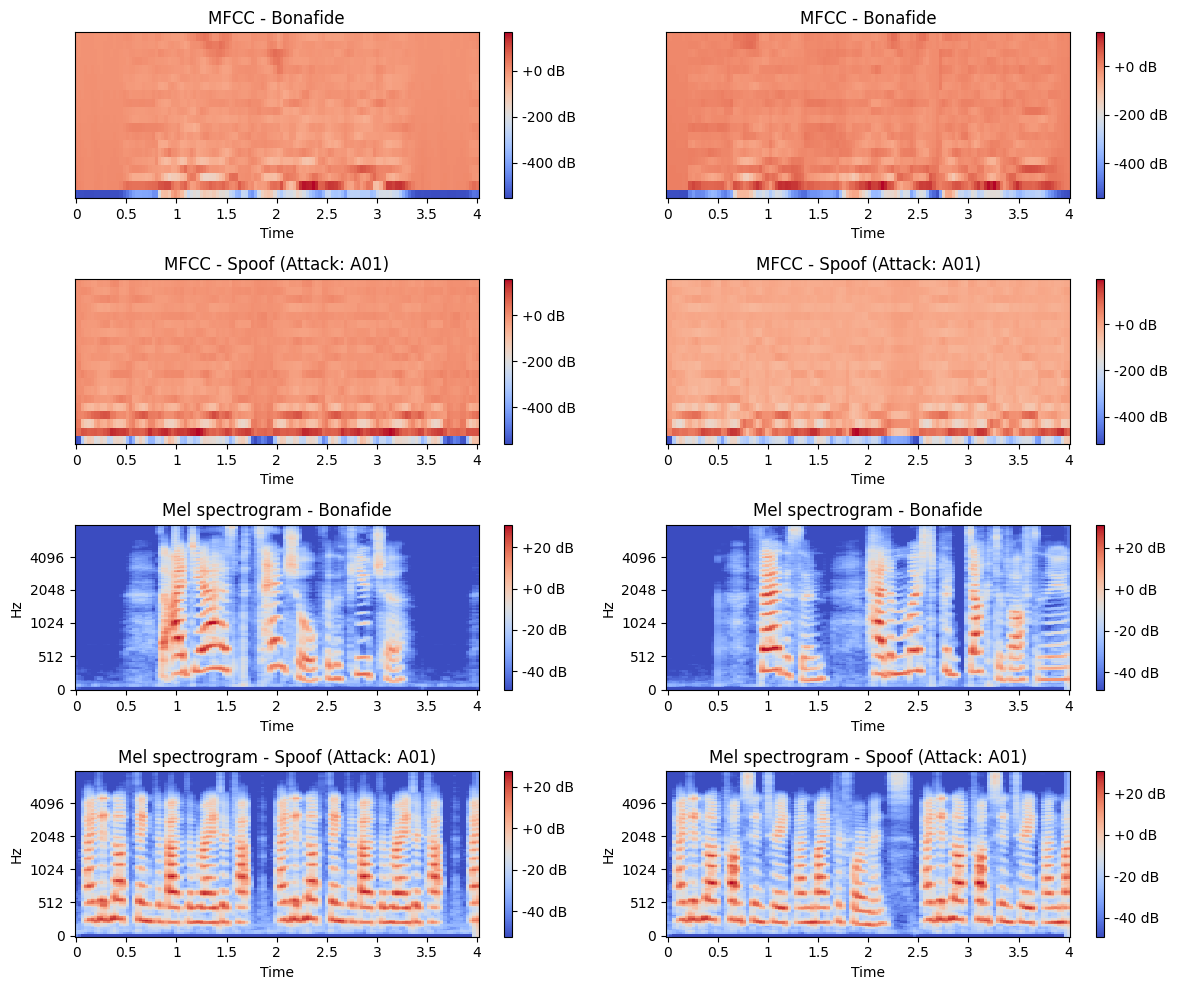

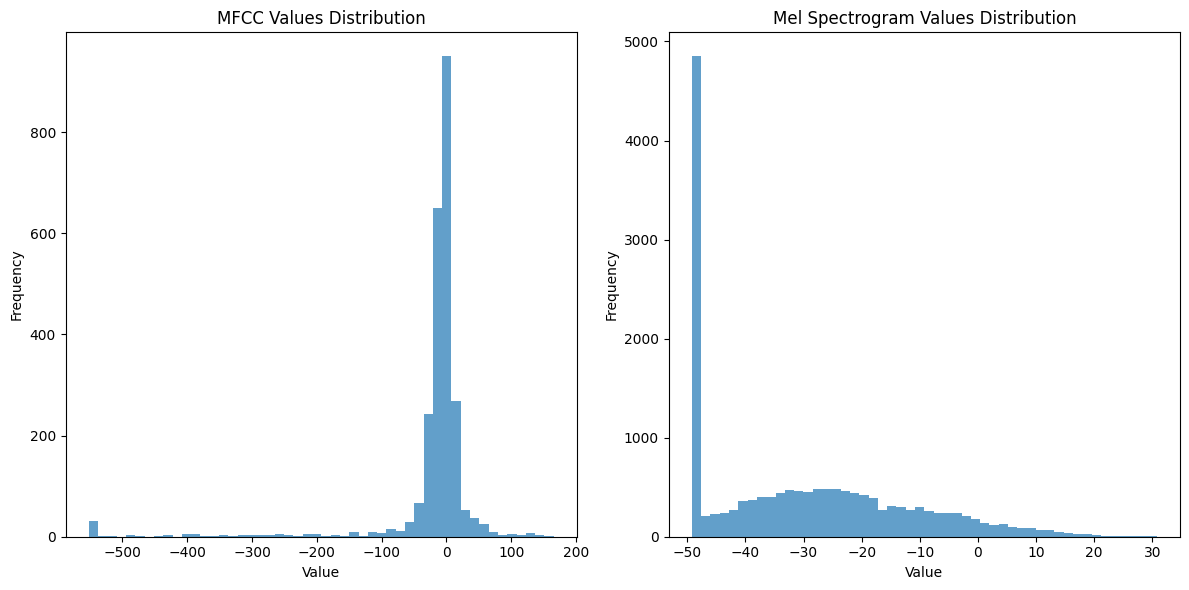


Class distribution:
Bonafide samples: 2580 (10.2%)
Spoof samples: 22800 (89.8%)

Attack types distribution:
Attack A01: 3800 samples (16.7%)
Attack A02: 3800 samples (16.7%)
Attack A03: 3800 samples (16.7%)
Attack A04: 3800 samples (16.7%)
Attack A05: 3800 samples (16.7%)
Attack A06: 3800 samples (16.7%)


In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# First, let's check the sizes of these datasets
print(f"MFCC dataset size: {len(train_dataset_mfcc)}")
print(f"Mel spectrogram dataset size: {len(train_dataset_mel)}")

# Get a sample from each dataset
mfcc_feature, mfcc_filename, mfcc_attack_id, mfcc_sys_id = train_dataset_mfcc[0]
mel_feature, mel_filename, mel_attack_id, mel_sys_id = train_dataset_mel[0]

# Display their shapes
print("\nFeature shapes:")
print(f"MFCC shape: {mfcc_feature.shape}")
print(f"Mel spectrogram shape: {mel_feature.shape}")

# Check the range of values
print("\nValue ranges:")
print(f"MFCC - min: {mfcc_feature.min():.2f}, max: {mfcc_feature.max():.2f}")
print(f"Mel - min: {mel_feature.min():.2f}, max: {mel_feature.max():.2f}")

# Check metadata
print("\nSample metadata:")
print(f"MFCC - Filename: {mfcc_filename}, Attack ID: {mfcc_attack_id}, System ID: {mfcc_sys_id}")
print(f"Mel - Filename: {mel_filename}, Attack ID: {mel_attack_id}, System ID: {mel_sys_id}")

# Visualize a few examples
plt.figure(figsize=(12, 10))

# Get a few examples of both bonafide and spoof for each feature type
bonafide_indices = [i for i, (_, _, _, sys_id) in enumerate(train_dataset_mfcc.features) if sys_id == 1][:2]
spoof_indices = [i for i, (_, _, _, sys_id) in enumerate(train_dataset_mfcc.features) if sys_id == 0][:2]

# Plot MFCCs
for i, idx in enumerate(bonafide_indices + spoof_indices):
    feature, filename, attack_id, sys_id = train_dataset_mfcc[idx]
    plt.subplot(4, 2, i+1)
    librosa.display.specshow(feature.T, x_axis='time', sr=16000)
    label = "Bonafide" if sys_id == 1 else f"Spoof (Attack: {attack_id})"
    plt.title(f"MFCC - {label}")
    plt.colorbar(format='%+2.0f dB')

# Plot Mel spectrograms
for i, idx in enumerate(bonafide_indices + spoof_indices):
    feature, filename, attack_id, sys_id = train_dataset_mel[idx]
    plt.subplot(4, 2, i+5)
    librosa.display.specshow(feature.T, x_axis='time', y_axis='mel', sr=16000)
    label = "Bonafide" if sys_id == 1 else f"Spoof (Attack: {attack_id})"
    plt.title(f"Mel spectrogram - {label}")
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Examine the distribution of features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(mfcc_feature.flatten(), bins=50, alpha=0.7)
plt.title('MFCC Values Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(mel_feature.flatten(), bins=50, alpha=0.7)
plt.title('Mel Spectrogram Values Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check the distribution of bonafide vs spoof samples
bonafide_count = sum(1 for _, _, _, sys_id in train_dataset_mfcc.features if sys_id == 1)
spoof_count = sum(1 for _, _, _, sys_id in train_dataset_mfcc.features if sys_id == 0)

print("\nClass distribution:")
print(f"Bonafide samples: {bonafide_count} ({bonafide_count/len(train_dataset_mfcc)*100:.1f}%)")
print(f"Spoof samples: {spoof_count} ({spoof_count/len(train_dataset_mfcc)*100:.1f}%)")

# Check the attack types distribution
attack_types = {}
for _, _, attack_id, sys_id in train_dataset_mfcc.features:
    if sys_id == 0:  # Only for spoof samples
        if attack_id not in attack_types:
            attack_types[attack_id] = 0
        attack_types[attack_id] += 1

print("\nAttack types distribution:")
for attack_id, count in attack_types.items():
    print(f"Attack {attack_id}: {count} samples ({count/spoof_count*100:.1f}%)")

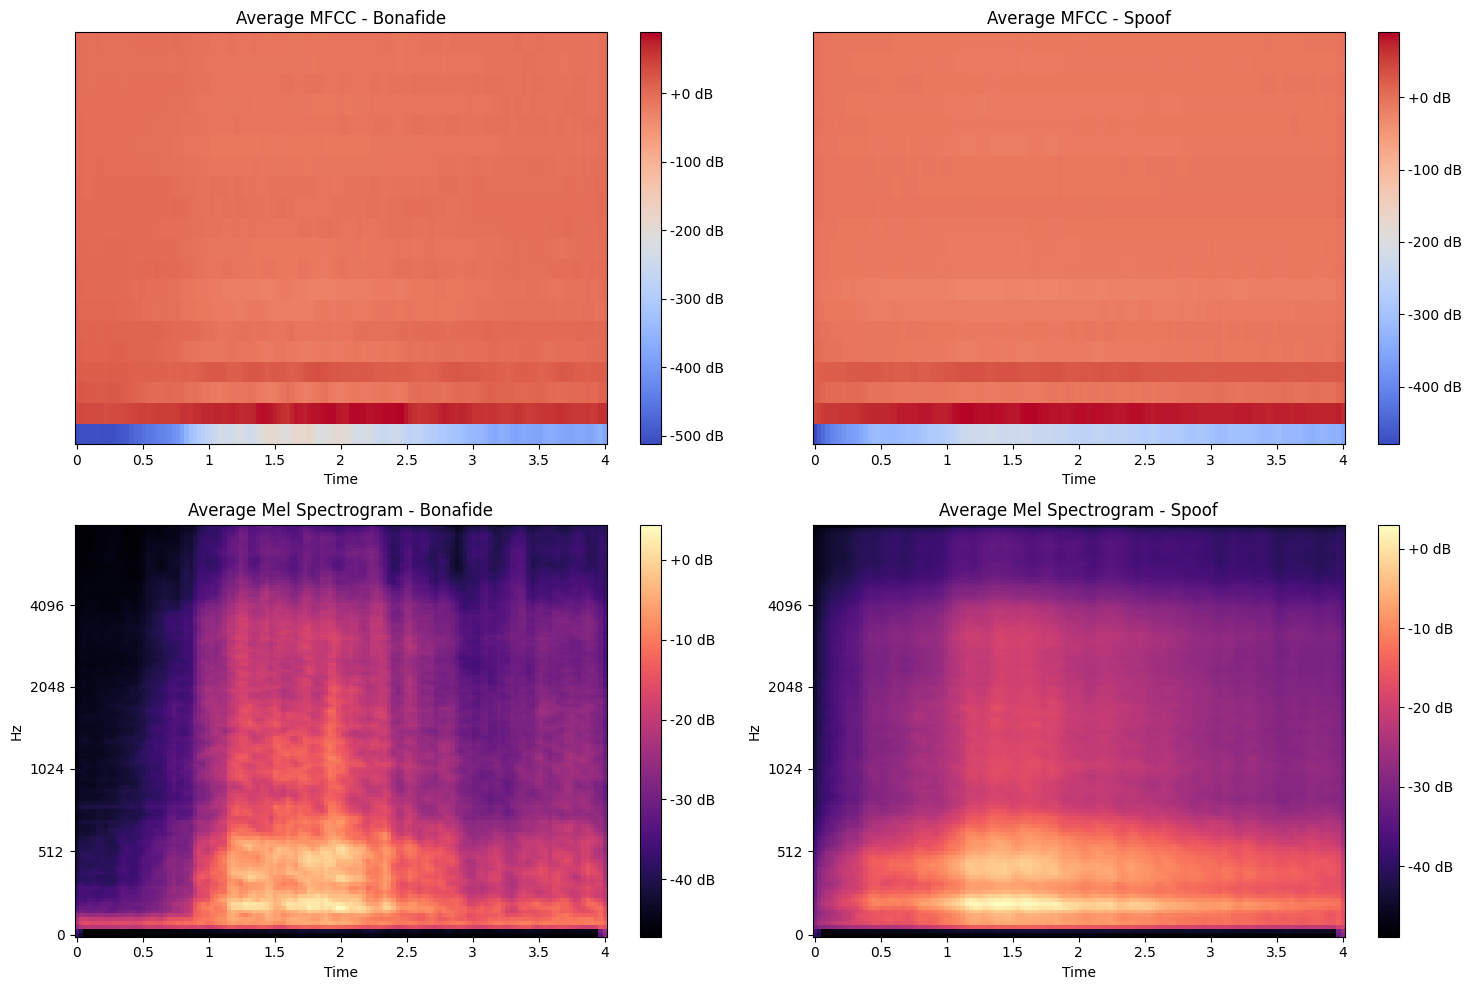

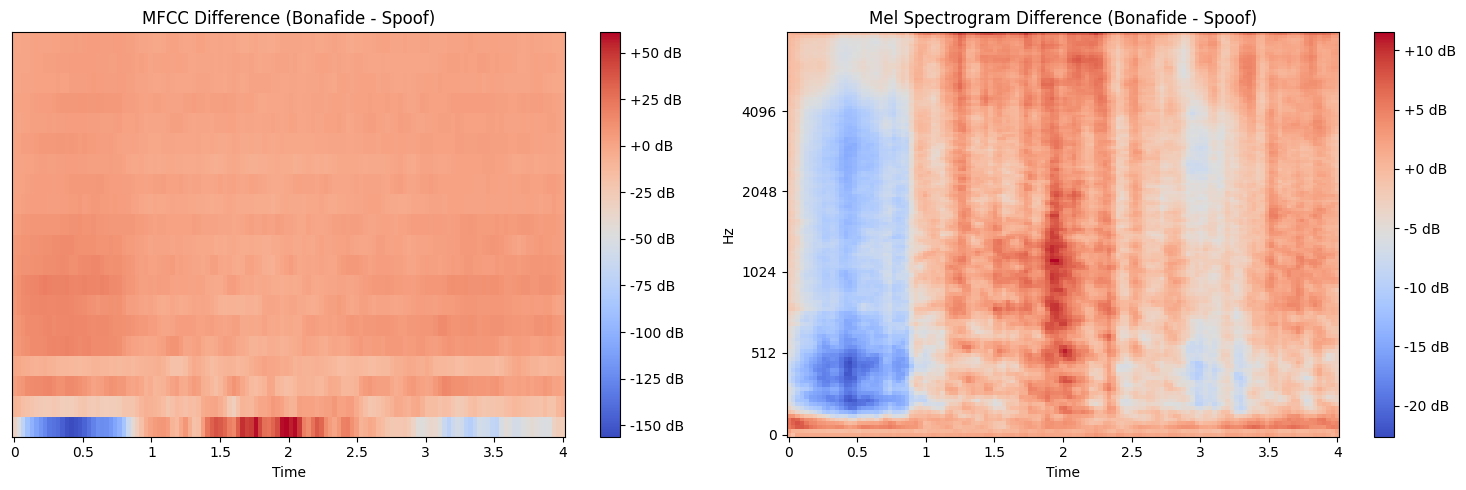

In [ ]:
import matplotlib.pyplot as plt
# Calculate average features for bonafide and spoof
def get_avg_features(dataset, feature_type='mfcc'):
    bonafide_features = []
    spoof_features = []

    # Sample a subset to speed up calculation
    sample_size = min(500, len(dataset))
    indices = np.random.choice(len(dataset), sample_size, replace=False)

    for idx in indices:
        feature, _, _, sys_id = dataset[idx]

        # Skip if feature has unexpected shape
        if feature_type == 'mfcc' and feature.shape[1] != 20:
            continue
        if feature_type == 'mel' and feature.shape[1] != 128:
            continue

        if sys_id == 1:
            bonafide_features.append(feature)
        else:
            spoof_features.append(feature)

    # Calculate mean across all features
    if bonafide_features and spoof_features:
        # Ensure all features have the same shape before averaging
        min_length = min(min(f.shape[0] for f in bonafide_features),
                          min(f.shape[0] for f in spoof_features))

        bonafide_features = [f[:min_length] for f in bonafide_features]
        spoof_features = [f[:min_length] for f in spoof_features]

        avg_bonafide = np.mean(bonafide_features, axis=0)
        avg_spoof = np.mean(spoof_features, axis=0)

        return avg_bonafide, avg_spoof

    return None, None

# Get average features
avg_bonafide_mfcc, avg_spoof_mfcc = get_avg_features(train_dataset_mfcc, 'mfcc')
avg_bonafide_mel, avg_spoof_mel = get_avg_features(train_dataset_mel, 'mel')

# Plot average features
if avg_bonafide_mfcc is not None and avg_spoof_mfcc is not None:
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    librosa.display.specshow(avg_bonafide_mfcc.T, x_axis='time', sr=16000)
    plt.title('Average MFCC - Bonafide')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 2, 2)
    librosa.display.specshow(avg_spoof_mfcc.T, x_axis='time', sr=16000)
    plt.title('Average MFCC - Spoof')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 2, 3)
    librosa.display.specshow(avg_bonafide_mel.T, x_axis='time', y_axis='mel', sr=16000)
    plt.title('Average Mel Spectrogram - Bonafide')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 2, 4)
    librosa.display.specshow(avg_spoof_mel.T, x_axis='time', y_axis='mel', sr=16000)
    plt.title('Average Mel Spectrogram - Spoof')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Plot the difference between bonafide and spoof
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    diff_mfcc = avg_bonafide_mfcc - avg_spoof_mfcc
    librosa.display.specshow(diff_mfcc.T, x_axis='time', sr=16000)
    plt.title('MFCC Difference (Bonafide - Spoof)')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(1, 2, 2)
    diff_mel = avg_bonafide_mel - avg_spoof_mel
    librosa.display.specshow(diff_mel.T, x_axis='time', y_axis='mel', sr=16000)
    plt.title('Mel Spectrogram Difference (Bonafide - Spoof)')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

## Dataset Structure

The dataset is organized into a "Logical Access" (LA) scenario, which contains audio recordings that have been created using different speech synthesis and voice conversion technologies. The directory structure is:

```
LA/
├── ASVspoof2019_LA_asv_protocols/     # Protocol files for ASV evaluation
├── ASVspoof2019_LA_asv_scores/        # Baseline ASV system scores
├── ASVspoof2019_LA_cm_protocols/      # Protocol files for countermeasures
├── ASVspoof2019_LA_dev/               # Development set audio files
├── ASVspoof2019_LA_eval/              # Evaluation set audio files
└── ASVspoof2019_LA_train/             # Training set audio files
```

## Audio Files

- All audio files are in FLAC format with 16 kHz sampling rate and 16-bit resolution
- The naming convention is:
  - Training set: LA_T_*.flac
  - Development set: LA_D_*.flac
  - Evaluation set: LA_E_*.flac

## Protocol Files

The protocol files (in `ASVspoof2019_LA_cm_protocols/`) describe:
- Which audio files to use for training, development, and evaluation
- The labels for each file (bonafide or spoof)
- What type of spoofing attack was used (if applicable)

The format of these protocol files is:
```
SPEAKER_ID AUDIO_FILE_NAME - SYSTEM_ID KEY
```

Where:
- SPEAKER_ID: A 4-digit speaker identifier (e.g., LA_0070)
- AUDIO_FILE_NAME: The name of the audio file (e.g., LA_D_7622198)
- SYSTEM_ID: For spoofed audio, this identifies the spoofing method (A01-A19); for bonafide speech, this is left blank (-)
- KEY: Either 'bonafide' for genuine speech or 'spoof' for spoofed speech

## Spoofing Methods

The dataset includes 19 different spoofing systems (A01-A19), which can be broadly categorized as:
- TTS (Text-to-Speech): A01, A02, A03, A04, A07, A08, A09, A10, A11, A12, A16
- VC (Voice Conversion): A05, A06, A17, A18, A19
- TTS+VC (Hybrid): A13, A14, A15

These systems use various technologies:
- Neural waveform models
- Vocoders
- Griffin-Lim algorithm
- Waveform concatenation
- Spectral filtering
- GAN-based approaches

## Dataset Statistics

Based on our exploration:
- Training set: 25,380 audio samples
  - 2,580 bonafide samples (10.2%)
  - 22,800 spoof samples (89.8%)
- Development set: 24,844 audio samples
- Evaluation set: 71,237 audio samples

The attack types are evenly distributed in the training set, with each of the 6 attack types (A01-A06) representing about 16.7% of the spoofed samples.

## Audio Features

We've examined two feature types:
1. **MFCCs (Mel-Frequency Cepstral Coefficients)**:
   - Compact representation (20 coefficients per frame)
   - Values typically clustered around zero
   - Less visual distinction between bonafide and spoofed samples

2. **Mel Spectrograms**:
   - Richer representation (128 frequency bins per frame)
   - More pronounced visual differences between bonafide and spoofed samples
   - Values typically between -50 and 30 dB

## Challenge Goal

Your task is to develop a system that can accurately distinguish between bonafide and spoofed speech. The performance is typically evaluated using the Equal Error Rate (EER) metric, which measures the point where false acceptance and false rejection rates are equal.

The primary challenge arises from:
1. The class imbalance (much more spoofed than bonafide data)
2. The variety of spoofing techniques used
3. The subtle acoustic differences between some spoofed and bonafide samples

This is fundamentally a binary classification task, but with significant real-world security implications for voice authentication systems.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader
import os
from pathlib import Path
import librosa
import soundfile as sf

class ASVspoofTester:
    def __init__(self, model, device, test_loader, criterion=None):
        """
        Initialize the tester with a trained model and test data loader.

        Args:
            model: The trained PyTorch model
            device: Device to run inference on ('cuda' or 'cpu')
            test_loader: DataLoader containing test data
            criterion: Loss function (optional)
        """
        self.model = model
        self.device = device
        self.test_loader = test_loader
        self.criterion = criterion

        # Move model to the specified device
        self.model.to(self.device)
        self.model.eval()

    def compute_eer(self, bonafide_scores, spoof_scores):
        """
        Compute Equal Error Rate (EER) from bonafide and spoof scores.

        Args:
            bonafide_scores: Scores for bonafide samples (higher = more likely to be bonafide)
            spoof_scores: Scores for spoof samples (higher = more likely to be bonafide)

        Returns:
            eer: Equal Error Rate
            threshold: Threshold at EER
        """
        # Create labels (1 for bonafide, 0 for spoof)
        y_true = np.concatenate([np.ones(len(bonafide_scores)), np.zeros(len(spoof_scores))])
        y_score = np.concatenate([bonafide_scores, spoof_scores])

        # Calculate ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(y_true, y_score)

        # Find the threshold where FAR (FPR) = FRR (1-TPR)
        fnr = 1 - tpr
        # Find the closest point to the EER line
        eer_idx = np.argmin(np.abs(fpr - fnr))
        eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
        eer_threshold = thresholds[eer_idx]

        return eer, eer_threshold

    def evaluate(self, return_outputs=False):
        """
        Evaluate the model on the test set.

        Args:
            return_outputs: Whether to return the model outputs and targets

        Returns:
            metrics: Dictionary of evaluation metrics
            outputs, targets: Model outputs and targets (if return_outputs=True)
        """
        all_outputs = []
        all_targets = []
        all_filenames = []
        all_attack_ids = []

        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for features, filenames, attack_ids, targets in self.test_loader:
                # Move data to device
                features = features.to(self.device).float()
                targets = targets.to(self.device)

                # Forward pass
                outputs = self.model(features)

                # Calculate loss if criterion is provided
                if self.criterion:
                    loss = self.criterion(outputs, targets)
                    total_loss += loss.item() * features.size(0)
                    total_samples += features.size(0)

                # Get predictions
                if isinstance(outputs, tuple):  # Handle multiple outputs
                    outputs = outputs[0]

                # For binary classification with single output node
                if outputs.shape[1] == 1:
                    probs = torch.sigmoid(outputs).squeeze()
                # For binary classification with two output nodes
                else:
                    probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (bonafide)

                # Collect outputs and targets for later analysis
                all_outputs.append(probs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
                all_filenames.extend(filenames)
                all_attack_ids.extend(attack_ids)

        # Concatenate results
        all_outputs = np.concatenate(all_outputs)
        all_targets = np.concatenate(all_targets)

        # Calculate average loss
        avg_loss = total_loss / total_samples if total_samples > 0 else 0

        # Calculate accuracy
        predicted_labels = (all_outputs > 0.5).astype(int)
        accuracy = np.mean(predicted_labels == all_targets)

        # Calculate EER
        bonafide_scores = all_outputs[all_targets == 1]
        spoof_scores = all_outputs[all_targets == 0]
        eer, threshold = self.compute_eer(bonafide_scores, spoof_scores)

        # Calculate ROC AUC
        fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
        roc_auc = auc(fpr, tpr)

        # Create confusion matrix
        cm = confusion_matrix(all_targets, predicted_labels)

        # Results per attack type
        attack_results = {}
        for attack_id in set(all_attack_ids):
            if attack_id == '-':  # bonafide
                continue

            # Find indices for this attack
            attack_indices = [i for i, a in enumerate(all_attack_ids) if a == attack_id]
            if not attack_indices:
                continue

            # Get scores and true labels for this attack
            attack_scores = all_outputs[attack_indices]
            attack_targets = all_targets[attack_indices]

            # Add bonafide samples for EER calculation
            bonafide_indices = [i for i, t in enumerate(all_targets) if t == 1]
            combined_scores = np.concatenate([attack_scores, all_outputs[bonafide_indices]])
            combined_targets = np.concatenate([attack_targets, all_targets[bonafide_indices]])

            # Calculate EER for this attack
            attack_predicted = (attack_scores > threshold).astype(int)
            attack_acc = np.mean(attack_predicted == attack_targets)

            # Get bonafide samples for EER calculation
            bonafide_scores_for_eer = all_outputs[all_targets == 1]
            attack_eer, _ = self.compute_eer(bonafide_scores_for_eer, attack_scores)

            attack_results[attack_id] = {
                'accuracy': attack_acc,
                'eer': attack_eer
            }

        # Store all metrics
        metrics = {
            'loss': avg_loss,
            'accuracy': accuracy,
            'eer': eer,
            'threshold': threshold,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'attack_results': attack_results,
            'fpr': fpr,
            'tpr': tpr,
            'all_outputs': all_outputs,
            'all_targets': all_targets,
            'all_filenames': all_filenames,
            'all_attack_ids': all_attack_ids
        }

        if return_outputs:
            return metrics, all_outputs, all_targets

        return metrics

    def visualize_results(self, metrics, save_dir=None):
        """
        Visualize evaluation results with various plots.

        Args:
            metrics: Dictionary of evaluation metrics from evaluate()
            save_dir: Directory to save plots (if None, plots are displayed)
        """
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # 1. Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(metrics['fpr'], metrics['tpr'], color='darkorange', lw=2,
                label=f"ROC curve (AUC = {metrics['roc_auc']:.3f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'roc_curve.png'))
            plt.close()
        else:
            plt.show()

        # 2. Plot score distributions
        bonafide_scores = metrics['all_outputs'][metrics['all_targets'] == 1]
        spoof_scores = metrics['all_outputs'][metrics['all_targets'] == 0]

        plt.figure(figsize=(10, 8))
        plt.hist(bonafide_scores, bins=50, alpha=0.5, label='Bonafide', density=True)
        plt.hist(spoof_scores, bins=50, alpha=0.5, label='Spoof', density=True)
        plt.axvline(x=metrics['threshold'], color='r', linestyle='--',
                   label=f"EER Threshold: {metrics['threshold']:.3f}")
        plt.xlabel('Score')
        plt.ylabel('Density')
        plt.title('Score Distributions')
        plt.legend()

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'score_distributions.png'))
            plt.close()
        else:
            plt.show()

        # 3. Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Spoof', 'Bonafide'], yticklabels=['Spoof', 'Bonafide'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        if save_dir:
            plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
            plt.close()
        else:
            plt.show()

        # 4. Plot EER by attack type
        attack_types = []
        attack_eers = []

        for attack_id, results in metrics['attack_results'].items():
            attack_types.append(attack_id)
            attack_eers.append(results['eer'])

        if attack_types:
            plt.figure(figsize=(12, 6))
            bars = plt.bar(attack_types, attack_eers)
            plt.axhline(y=metrics['eer'], color='r', linestyle='--',
                       label=f"Overall EER: {metrics['eer']:.3f}")
            plt.xlabel('Attack Type')
            plt.ylabel('EER')
            plt.title('Equal Error Rate by Attack Type')

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom')

            plt.legend()

            if save_dir:
                plt.savefig(os.path.join(save_dir, 'eer_by_attack.png'))
                plt.close()
            else:
                plt.show()

    def analyze_errors(self, metrics, n_examples=5, audio_dir=None):
        """
        Analyze misclassified examples.

        Args:
            metrics: Dictionary of evaluation metrics from evaluate()
            n_examples: Number of examples to analyze for each error type
            audio_dir: Directory containing audio files (if provided, will attempt to load audio)
        """
        all_outputs = metrics['all_outputs']
        all_targets = metrics['all_targets']
        all_filenames = metrics['all_filenames']
        all_attack_ids = metrics['all_attack_ids']

        # Find false positives (spoof predicted as bonafide)
        fp_indices = np.where((all_targets == 0) & (all_outputs > 0.5))[0]

        # Find false negatives (bonafide predicted as spoof)
        fn_indices = np.where((all_targets == 1) & (all_outputs <= 0.5))[0]

        print(f"Total false positives: {len(fp_indices)}")
        print(f"Total false negatives: {len(fn_indices)}")

        # Sample examples
        if len(fp_indices) > 0:
            print("\nFalse Positive Examples (Spoof classified as Bonafide):")
            sample_fp = np.random.choice(fp_indices, min(n_examples, len(fp_indices)), replace=False)
            for idx in sample_fp:
                print(f"File: {all_filenames[idx]}, Attack: {all_attack_ids[idx]}, Score: {all_outputs[idx]:.3f}")

                # If audio directory is provided, try to load and analyze audio
                if audio_dir:
                    self._analyze_audio_file(all_filenames[idx], audio_dir)

        if len(fn_indices) > 0:
            print("\nFalse Negative Examples (Bonafide classified as Spoof):")
            sample_fn = np.random.choice(fn_indices, min(n_examples, len(fn_indices)), replace=False)
            for idx in sample_fn:
                print(f"File: {all_filenames[idx]}, Score: {all_outputs[idx]:.3f}")

                # If audio directory is provided, try to load and analyze audio
                if audio_dir:
                    self._analyze_audio_file(all_filenames[idx], audio_dir)

    def _analyze_audio_file(self, filename, audio_dir):
        """Analyze an audio file with visualizations."""
        try:
            # Determine the partition (train, dev, eval) from filename
            if filename.startswith('LA_T'):
                partition = 'ASVspoof2019_LA_train'
            elif filename.startswith('LA_D'):
                partition = 'ASVspoof2019_LA_dev'
            elif filename.startswith('LA_E'):
                partition = 'ASVspoof2019_LA_eval'
            else:
                print(f"Unknown partition for file {filename}")
                return

            # Try to find the audio file
            audio_path = Path(audio_dir) / partition / (filename + '.flac')
            if not os.path.exists(audio_path):
                audio_path = Path(audio_dir) / partition / 'flac' / (filename + '.flac')
                if not os.path.exists(audio_path):
                    print(f"Audio file not found: {audio_path}")
                    return

            # Load audio
            audio, sr = librosa.load(audio_path, sr=16000)

            # Plot waveform
            plt.figure(figsize=(12, 8))

            plt.subplot(3, 1, 1)
            plt.plot(np.arange(len(audio)) / sr, audio)
            plt.title(f"Waveform - {filename}")
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')

            # Plot spectrogram
            plt.subplot(3, 1, 2)
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
            mel_spec_db = librosa.power_to_db(mel_spec)
            librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
            plt.colorbar(format='%+2.0f dB')
            plt.title("Mel Spectrogram")

            # Plot MFCC
            plt.subplot(3, 1, 3)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
            librosa.display.specshow(mfcc, x_axis='time', sr=sr)
            plt.colorbar()
            plt.title("MFCC")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error analyzing audio file: {e}")

In [ ]:
def define_search_space():
    search_space = {
        # Feature Extraction Layers
        'spectrogram_type': ['mel', 'mfcc', 'stft', 'cqt'],  # Different spectral representations
        'num_mfcc_coeffs': [13, 20, 40],  # If MFCC is used
        'num_mel_bins': [40, 64, 128],  # If Mel spectrogram is used

        # Convolutional Feature Extraction
        'conv_filters': [32, 64, 128, 256],  # Number of filters in CNN layers
        'conv_kernel_sizes': [3, 5, 7],  # Kernel sizes for CNN layers
        'conv_blocks': [2, 3, 4],  # Number of convolutional blocks

        # Temporal Modeling (Recurrent Layers)
        'rnn_type': ['LSTM', 'GRU', 'BiLSTM', 'BiGRU', None],  # Types of RNNs
        'rnn_hidden_size': [64, 128, 256],  # Hidden units in RNN layers
        'rnn_layers': [1, 2, 3],  # Number of RNN layers

        # Transformer & Self-Attention Mechanisms
        'use_transformer_encoder': [True, False],  # Whether to use Transformer-based feature extraction
        'num_attention_heads': [4, 8],  # Number of attention heads
        'feedforward_dim': [256, 512],  # Feedforward dimension in attention layers

        # Pooling Operations
        'pooling_type': ['max', 'average', 'self_attention'],  # How to aggregate features

        # Normalization Strategies
        'normalization': ['batch_norm', 'layer_norm', 'instance_norm', None],

        # Skip Connections & Residual Learning
        'use_skip_connections': [True, False],
        'use_residual_blocks': [True, False],

        # Output Layer & Activation
        'activation_function': ['relu', 'gelu', 'leaky_relu'],
        'dropout_rate': [0.1, 0.2, 0.3, 0.5],

        # Training Hyperparameters
        'optimizer': ['adam', 'rmsprop', 'sgd'],
        'learning_rate': [1e-3, 1e-4, 1e-5],
        'batch_size': [16, 32, 64],
    }
    return search_space


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NASController(nn.Module):
    def __init__(self, search_space, embedding_size=64, lstm_hidden_size=128):
        super(NASController, self).__init__()
        self.search_space = search_space
        self.embedding_size = embedding_size
        self.lstm_hidden_size = lstm_hidden_size

        # Create embeddings for each decision
        self.embeddings = nn.ModuleDict({
            key: nn.Embedding(len(options), embedding_size)
            for key, options in search_space.items()
        })

        # Controller LSTM
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=lstm_hidden_size, batch_first=True)

        # Decision heads (one for each architectural choice)
        self.decision_heads = nn.ModuleDict({
            key: nn.Linear(lstm_hidden_size, len(options))
            for key, options in search_space.items()
        })

    def forward(self, batch_size, training=False, device="cpu"):
        # Initialize LSTM hidden and cell states
        batch_size = len(train_dataset_mfcc)
        print(batch_size)
        if isinstance(batch_size, torch.Tensor):
            batch_size = batch_size.item()  # Convert tensor to integer
        elif isinstance(batch_size, float):
            batch_size = int(batch_size)  # Convert float to integer

        # Initialize LSTM hidden and cell states
        print(f"DEBUG: batch_size type is {type(batch_size)}, value: {batch_size}")

        h = torch.zeros((1, batch_size, self.lstm_hidden_size)).to(device)
        c = torch.zeros((1, batch_size, self.lstm_hidden_size)).to(device)

        lstm_input = torch.zeros(batch_size, 1, self.embedding_size).to(device)  # Initial input

        architecture = {}
        log_probs = []

        # Generate each architectural decision sequentially
        for key in self.search_space.keys():
            output, (h, c) = self.lstm(lstm_input, (h, c))
            logits = self.decision_heads[key](output[:, -1, :])

            if training:
                distribution = torch.distributions.Categorical(logits=logits)
                choice = distribution.sample()
            else:
                choice = torch.argmax(logits, dim=-1)

            # Store the architecture choice
            architecture[key] = choice[0].cpu().item() if not training else choice[0].item() # Convert to NumPy in inference mode

            # Compute log probabilities for PPO training
            log_prob = -F.cross_entropy(logits, choice, reduction='none')
            log_probs.append(log_prob)

            # Use the embedding of the chosen option as input for the next decision
            choice_embedding = self.embeddings[key](choice)
            lstm_input = choice_embedding.unsqueeze(1)  # Add sequence dimension

        return architecture, torch.stack(log_probs, dim=1)




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepfakeAudioDetector(nn.Module):
    def __init__(self, architecture_params, input_shape, num_classes):
        super(DeepfakeAudioDetector, self).__init__()

        self.input_shape = input_shape
        self.num_classes = num_classes

        # Convolutional layers
        for kernel_size in architecture_params['conv_kernel_sizes']:
    # Apply kernel_size in your convolution layers
          print(f"Using kernel size: {kernel_size}")
        filters = architecture_params['conv_filters']
        print(type(architecture_params['conv_kernel_sizes']))
        print(architecture_params['conv_kernel_sizes'])

        self.conv1 = nn.Conv1d(input_shape[1], filters, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(filters, filters * 2, kernel_size, padding='same')

        # Normalization
        norm_type = architecture_params['normalization']
        if norm_type == 'batch_norm':
            self.norm1 = nn.BatchNorm1d(filters)
            self.norm2 = nn.BatchNorm1d(filters * 2)
        elif norm_type == 'layer_norm':
            self.norm1 = nn.LayerNorm([filters, input_shape[0]])
            self.norm2 = nn.LayerNorm([filters * 2, input_shape[0] // 2])
        else:
            self.norm1 = self.norm2 = None

        # RNN layer
        rnn_type = architecture_params['rnn_type']
        rnn_hidden_size = 128
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(filters * 2, rnn_hidden_size, batch_first=True, bidirectional=False)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(filters * 2, rnn_hidden_size, batch_first=True, bidirectional=False)
        elif rnn_type == 'BiLSTM':
            self.rnn = nn.LSTM(filters * 2, rnn_hidden_size, batch_first=True, bidirectional=True)
        elif rnn_type == 'BiGRU':
            self.rnn = nn.GRU(filters * 2, rnn_hidden_size, batch_first=True, bidirectional=True)

        # Attention
        self.use_attention = architecture_params['attention_type'] is not None
        if self.use_attention:
            self.attention_query = nn.Linear(rnn_hidden_size, 128)
            self.attention_key = nn.Linear(rnn_hidden_size, 128)
            self.attention_value = nn.Linear(rnn_hidden_size, 128)

        # Pooling
        self.pooling_type = architecture_params['pooling_type']

        # Fully connected layers
        self.fc1 = nn.Linear(rnn_hidden_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Swap dimensions for Conv1D (batch, channels, time)
        x = self.conv1(x)
        if self.norm1:
            x = self.norm1(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=2)

        x = self.conv2(x)
        if self.norm2:
            x = self.norm2(x)
        x = F.relu(x)
        x = F.max_pool1d(x, kernel_size=2)

        x = x.permute(0, 2, 1)  # Swap back for RNN (batch, time, features)
        x, _ = self.rnn(x)

        if self.use_attention:
            query = self.attention_query(x)
            key = self.attention_key(x)
            value = self.attention_value(x)
            attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (key.size(-1) ** 0.5)
            attention_weights = F.softmax(attention_scores, dim=-1)
            x = torch.matmul(attention_weights, value)

        if self.pooling_type == 'max':
            x, _ = torch.max(x, dim=1)
        elif self.pooling_type == 'average':
            x = torch.mean(x, dim=1)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PPOTrainer:
    def __init__(self, controller, build_fn, train_dataset, val_dataset, input_shape, num_classes):
        self.controller = controller
        self.build_fn = build_fn
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.input_shape = input_shape
        self.num_classes = num_classes

        # PPO hyperparameters
        self.clip_ratio = 0.2
        self.policy_learning_rate = 1e-4
        self.optimizer = optim.Adam(self.controller.parameters(), lr=self.policy_learning_rate)

        # Reward normalization
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_history = []

    def update_reward_stats(self, reward):
        self.reward_history.append(reward)
        if len(self.reward_history) > 20:  # Keep a moving window
            self.reward_history.pop(0)

        self.reward_mean = np.mean(self.reward_history)
        self.reward_std = np.std(self.reward_history) + 1e-6  # Avoid division by zero

        return (reward - self.reward_mean) / self.reward_std

    def train_step(self, batch_size=1):
        self.controller.train()

        if isinstance(batch_size, torch.Tensor):
            batch_size = batch_size.item()  # Convert tensor to int
        if isinstance(batch_size, float):
            batch_size = int(batch_size)  # Convert float to int

        # Generate architectures
        dummy_input = torch.zeros((batch_size, 1))  # Dummy input for the controller
        architecture_params, old_log_probs = self.controller(dummy_input, training=True)

        # Convert architecture parameters to actual values
        architecture_values = {}
        for key, indices in architecture_params.items():
            if isinstance(indices, int):
              indices = [indices]  # Convert it to a list
            elif isinstance(indices, torch.Tensor):
              indices = indices.detach().cpu().numpy()  # Convert tensor to numpy array

            architecture_values[key] = [self.controller.search_space[key][i] for i in indices]


        print("Architecture Params:", architecture_values.keys())

        # Build and train the child model
        model = self.build_fn(architecture_values, self.input_shape, self.num_classes)
        model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        # Train for a few epochs (low-fidelity evaluation)
        model.train()
        for epoch in range(3):  # Few epochs for efficiency
            for batch in self.train_dataset:
                inputs, targets = batch
                inputs, targets = inputs.to('cuda'), targets.to('cuda')

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for batch in self.val_dataset:
                inputs, targets = batch
                inputs, targets = inputs.to('cuda'), targets.to('cuda')
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        # Compute validation accuracy as reward
        reward = correct / total

        # Normalize reward
        normalized_reward = self.update_reward_stats(reward)

        # PPO objective
        advantages = torch.ones_like(old_log_probs) * normalized_reward

        # Generate architectures again to compute new log probs
        _, new_log_probs = self.controller(dummy_input, training=True)

        # Compute ratio and clipped objective
        ratio = torch.exp(new_log_probs - old_log_probs)
        clipped_ratio = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio)

        policy_loss = -torch.mean(torch.min(ratio * advantages, clipped_ratio * advantages))

        # Update controller weights
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        return {
            'policy_loss': policy_loss.item(),
            'reward': reward,
            'normalized_reward': normalized_reward
        }


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_nas(search_space, train_dataset, val_dataset, test_dataset, input_shape, num_classes,
              num_search_iterations=100, batch_size=1):
    # Initialize controller
    controller = NASController(search_space).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Use DeepFakeAudioDetector as the build function
    def build_fn(architecture_params, input_shape, num_classes):
        return DeepfakeAudioDetector(input_shape, num_classes, architecture_params).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize PPO trainer
    ppo_trainer = PPOTrainer(
        controller=controller,
        build_fn=build_fn,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        input_shape=input_shape,
        num_classes=num_classes
    )

    best_architecture = None
    best_performance = 0

    for iteration in range(num_search_iterations):
        print(f"NAS Iteration {iteration+1}/{num_search_iterations}")
        if isinstance(batch_size, torch.Tensor):
          batch_size = batch_size.item()
        metrics = ppo_trainer.train_step(batch_size)

        print(f"  Policy Loss: {metrics['policy_loss']:.4f}")
        print(f"  Reward (Val Accuracy): {metrics['reward']:.4f}")

        if metrics['reward'] > best_performance:
            dummy_input = torch.zeros((1, 1)).to('cuda' if torch.cuda.is_available() else 'cpu')
            architecture_params, _ = controller(dummy_input, training=False)

            best_architecture = {
                key: controller.search_space[key][indices.cpu().numpy()[0]]
                for key, indices in architecture_params.items()
            }

            best_performance = metrics['reward']
            print(f"  New best architecture found! Performance: {best_performance:.4f}")
            print(f"  Architecture: {best_architecture}")

    # Train final best model
    print("\nTraining the best architecture for final evaluation...")
    best_model = build_fn(best_architecture, input_shape, num_classes)
    best_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=1e-3)

    best_model.train()
    for epoch in range(20):
        print(f"Epoch {epoch + 1}/20")
        running_loss = 0.0
        correct, total = 0, 0

        for batch in train_dataset:
            inputs, targets = batch
            inputs, targets = inputs.to('cuda'), targets.to('cuda')

            optimizer.zero_grad()
            outputs = best_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        print(f"  Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Evaluate on test dataset
    best_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_dataset:
            inputs, targets = batch
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = best_model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    test_acc = correct / total
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    return best_architecture, best_model


In [ ]:
input_shape_mfcc = (128, 13)  # Adjust based on your feature extraction
input_shape_mel = (128, 128)  # Adjust for mel spectrogram

# Define search space for DeepFakeAudioDetector
search_space = define_search_space()
num_classes = 2
# NAS training for MFCC features
best_architecture_mfcc, best_model_mfcc = train_nas(
    search_space,
    train_dataset_mfcc,
    train_dataset_mel,
    train_dataset_mfcc,
    input_shape_mfcc,
    num_classes,
    num_search_iterations=10  # Adjust based on training needs
)

# NAS training for Mel spectrograms
best_architecture_mel, best_model_mel = train_nas(
    search_space,
    train_dataset_mel,
    train_dataset_mfcc,
    train_dataset_mel,
    input_shape_mel,
    num_classes,
    num_search_iterations=10
)


NAS Iteration 1/10
25380
DEBUG: batch_size type is <class 'int'>, value: 25380


In [ ]:
# Fix 1: Improved NASController with proper type handling

import torch
import torch.nn as nn
import torch.nn.functional as F

class NASController(nn.Module):
    def __init__(self, search_space, embedding_size=64, lstm_hidden_size=128):
        super(NASController, self).__init__()
        self.search_space = search_space
        self.embedding_size = embedding_size
        self.lstm_hidden_size = lstm_hidden_size

        # Create embeddings for each decision
        self.embeddings = nn.ModuleDict()
        for key, options in search_space.items():
            self.embeddings[key] = nn.Embedding(len(options), embedding_size)

        # Controller LSTM
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=lstm_hidden_size, batch_first=True)

        # Decision heads (one for each architectural choice)
        self.decision_heads = nn.ModuleDict()
        for key, options in search_space.items():
            self.decision_heads[key] = nn.Linear(lstm_hidden_size, len(options))

    def forward(self, batch_size=1, training=False, device="cuda"):
        """
        Generate architecture parameters

        Args:
            batch_size: Integer or tensor specifying batch size
            training: Boolean to indicate training mode
            device: Device to run on

        Returns:
            architecture: Dict of architecture choices
            log_probs: Log probabilities for PPO training
        """
        # Handle batch size properly
        if isinstance(batch_size, torch.Tensor):
            batch_size = batch_size.item()
        elif isinstance(batch_size, float):
            batch_size = int(batch_size)

        # Initialize LSTM hidden and cell states
        h = torch.zeros(1, batch_size, self.lstm_hidden_size).to(device)
        c = torch.zeros(1, batch_size, self.lstm_hidden_size).to(device)

        # Initial token embedding (zeros)
        lstm_input = torch.zeros(batch_size, 1, self.embedding_size).to(device)

        architecture = {}
        log_probs = []

        # Generate each architectural decision sequentially
        for key in self.search_space.keys():
            # LSTM forward pass
            output, (h, c) = self.lstm(lstm_input, (h, c))

            # Get logits for current decision
            logits = self.decision_heads[key](output[:, -1, :])

            # Sample from distribution during training, or take argmax during inference
            if training:
                distribution = torch.distributions.Categorical(logits=logits)
                choice = distribution.sample()
                log_prob = distribution.log_prob(choice)
            else:
                choice = torch.argmax(logits, dim=-1)
                log_prob = torch.zeros(batch_size).to(device)

            # Store the architecture choice (as integer)
            architecture[key] = choice.detach().cpu().tolist()

            # Store log probability
            log_probs.append(log_prob)

            # Use the embedding of the chosen option as input for the next decision
            choice_embedding = self.embeddings[key](choice)
            lstm_input = choice_embedding.unsqueeze(1)  # Add sequence dimension

        # Convert single item lists to integers for easier handling
        for key, value in architecture.items():
            if len(value) == 1:
                architecture[key] = value[0]

        return architecture, torch.stack(log_probs, dim=1)


# Fix 2: Improved DeepfakeAudioDetector that properly interprets architecture parameters

class DeepfakeAudioDetector(nn.Module):
    def __init__(self, input_shape, num_classes, architecture_params):
        super(DeepfakeAudioDetector, self).__init__()

        self.input_shape = input_shape
        self.num_classes = num_classes

        # Safe access to architecture parameters with defaults
        def get_param(key, default=None):
            if key in architecture_params:
                return architecture_params[key]
            return default

        # Extract parameters with proper defaults
        spectrogram_type = get_param('spectrogram_type', 'mel')
        filters = get_param('conv_filters', 64)
        kernel_size = get_param('conv_kernel_sizes', 3)
        if isinstance(kernel_size, list):
            kernel_size = kernel_size[0]

        # Proper padding calculation for conv layers
        padding = kernel_size // 2

        # Feature extraction layers
        self.conv1 = nn.Conv1d(
            in_channels=input_shape[1],
            out_channels=filters,
            kernel_size=kernel_size,
            padding=padding
        )

        self.conv2 = nn.Conv1d(
            in_channels=filters,
            out_channels=filters * 2,
            kernel_size=kernel_size,
            padding=padding
        )

        # Normalization
        norm_type = get_param('normalization', 'batch_norm')
        if norm_type == 'batch_norm':
            self.norm1 = nn.BatchNorm1d(filters)
            self.norm2 = nn.BatchNorm1d(filters * 2)
        elif norm_type == 'layer_norm':
            # Layer norm expects [N, C, L]
            self.norm1 = nn.LayerNorm([filters, input_shape[0]])
            self.norm2 = nn.LayerNorm([filters * 2, input_shape[0] // 2])
        elif norm_type == 'instance_norm':
            self.norm1 = nn.InstanceNorm1d(filters)
            self.norm2 = nn.InstanceNorm1d(filters * 2)
        else:
            self.norm1 = self.norm2 = None

        # Activation function
        activation = get_param('activation_function', 'relu')
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'leaky_relu':
            self.activation = F.leaky_relu
        elif activation == 'gelu':
            self.activation = F.gelu
        else:
            self.activation = F.relu

        # RNN layer
        rnn_type = get_param('rnn_type', 'LSTM')
        rnn_hidden_size = get_param('rnn_hidden_size', 128)
        self.rnn_bidirectional = rnn_type.startswith('Bi') if rnn_type else False

        # Fix to determine output size from RNN
        rnn_output_size = rnn_hidden_size * 2 if self.rnn_bidirectional else rnn_hidden_size

        if rnn_type in ['LSTM', 'BiLSTM']:
            self.rnn = nn.LSTM(
                input_size=filters * 2,
                hidden_size=rnn_hidden_size,
                batch_first=True,
                bidirectional=self.rnn_bidirectional
            )
        elif rnn_type in ['GRU', 'BiGRU']:
            self.rnn = nn.GRU(
                input_size=filters * 2,
                hidden_size=rnn_hidden_size,
                batch_first=True,
                bidirectional=self.rnn_bidirectional
            )
        else:
            self.rnn = None

        # Attention mechanism
        attention_type = get_param('pooling_type', None)
        self.use_attention = attention_type == 'self_attention'

        if self.use_attention:
            self.attention_query = nn.Linear(rnn_output_size, 128)
            self.attention_key = nn.Linear(rnn_output_size, 128)
            self.attention_value = nn.Linear(rnn_output_size, 128)

        # Pooling
        self.pooling_type = get_param('pooling_type', 'max')

        # Dropout
        self.dropout_rate = get_param('dropout_rate', 0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(rnn_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Handle 2D (batch, features, time) or 3D input (batch, time, features)
        if x.dim() == 3 and x.shape[1] > x.shape[2]:
            x = x.permute(0, 2, 1)  # Swap dimensions for Conv1D (batch, channels, time)

        # Convolutional feature extraction
        x = self.conv1(x)
        if self.norm1:
            x = self.norm1(x)
        x = self.activation(x)
        x = F.max_pool1d(x, kernel_size=2)

        x = self.conv2(x)
        if self.norm2:
            x = self.norm2(x)
        x = self.activation(x)
        x = F.max_pool1d(x, kernel_size=2)

        # Prepare for RNN (batch, time, features)
        x = x.permute(0, 2, 1)

        # RNN processing
        if self.rnn is not None:
            x, _ = self.rnn(x)

        # Apply attention if specified
        if self.use_attention:
            query = self.attention_query(x)
            key = self.attention_key(x)
            value = self.attention_value(x)

            # Scaled dot-product attention
            attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (key.size(-1) ** 0.5)
            attention_weights = F.softmax(attention_scores, dim=-1)
            x = torch.matmul(attention_weights, value)

        # Pooling
        if self.pooling_type == 'max':
            x, _ = torch.max(x, dim=1)
        elif self.pooling_type == 'average':
            x = torch.mean(x, dim=1)
        elif not self.use_attention:  # If not attention and not max/avg, use max as default
            x, _ = torch.max(x, dim=1)

        # Fully connected layers
        x = self.activation(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.fc2(x)

        return x  # Return raw logits, let loss function handle softmax


# Fix 3: Improved PPOTrainer with better type handling and error checking

class PPOTrainer:
    def __init__(self, controller, build_fn, train_dataset, val_dataset, input_shape, num_classes):
        self.controller = controller
        self.build_fn = build_fn
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.input_shape = input_shape
        self.num_classes = num_classes

        # Move controller to appropriate device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.controller = self.controller.to(self.device)

        # PPO hyperparameters
        self.clip_ratio = 0.2
        self.policy_learning_rate = 1e-4
        self.optimizer = torch.optim.Adam(self.controller.parameters(), lr=self.policy_learning_rate)

        # Reward statistics for normalization
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_history = []

        # Create data loaders if needed
        if not isinstance(train_dataset, torch.utils.data.DataLoader):
            self.train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=32, shuffle=True
            )
        else:
            self.train_loader = train_dataset

        if not isinstance(val_dataset, torch.utils.data.DataLoader):
            self.val_loader = torch.utils.data.DataLoader(
                val_dataset, batch_size=32, shuffle=False
            )
        else:
            self.val_loader = val_dataset

    def update_reward_stats(self, reward):
        """Update reward statistics for normalization"""
        self.reward_history.append(reward)
        if len(self.reward_history) > 20:  # Keep a moving window
            self.reward_history.pop(0)

        self.reward_mean = np.mean(self.reward_history)
        self.reward_std = np.std(self.reward_history) + 1e-6  # Avoid division by zero

        return (reward - self.reward_mean) / self.reward_std

    def map_architecture_to_values(self, architecture_params):
        """
        Convert architecture parameter indices to actual values
        """
        architecture_values = {}

        for key, index in architecture_params.items():
            # Handle different types of indices
            if isinstance(index, list):
                # If it's already a list (batch size > 1)
                indices = index
            elif isinstance(index, int):
                # If it's a single integer
                indices = [index]
            else:
                # If it's a tensor, convert to list
                indices = [index.item()] if isinstance(index, torch.Tensor) else [index]

            # Map indices to actual values from search space
            try:
                architecture_values[key] = self.controller.search_space[key][indices[0]]
            except (IndexError, KeyError) as e:
                print(f"Error accessing search space: {e}")
                print(f"Key: {key}, Index: {indices[0]}")
                print(f"Search space keys: {self.controller.search_space.keys()}")
                # Use a default value instead of crashing
                if key in self.controller.search_space:
                    architecture_values[key] = self.controller.search_space[key][0]
                else:
                    # Provide sensible defaults for common parameters
                    defaults = {
                        'spectrogram_type': 'mel',
                        'conv_filters': 64,
                        'conv_kernel_sizes': 3,
                        'rnn_type': 'LSTM',
                        'normalization': 'batch_norm',
                        'pooling_type': 'max',
                        'use_skip_connections': False,
                        'activation_function': 'relu',
                        'dropout_rate': 0.3
                    }
                    architecture_values[key] = defaults.get(key, None)

        return architecture_values

    def train_step(self, batch_size=1):
        """Train the controller for one step"""
        self.controller.train()

        # Handle batch size
        if isinstance(batch_size, torch.Tensor):
            batch_size = batch_size.item()
        if isinstance(batch_size, float):
            batch_size = int(batch_size)

        # Generate architecture
        architecture_params, old_log_probs = self.controller(
            batch_size=batch_size,
            training=True,
            device=self.device
        )

        # Convert architecture to actual values
        architecture_values = self.map_architecture_to_values(architecture_params)

        try:
            # Build and train the child model
            model = self.build_fn(self.input_shape, self.num_classes, architecture_values)
            model = model.to(self.device)

            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            # Train for a few epochs
            model.train()
            for epoch in range(2):  # Few epochs for efficiency
                for batch_idx, batch in enumerate(self.train_loader):
                    inputs, targets = batch

                    # Handle different dataset formats
                    if isinstance(inputs, list) and len(inputs) >= 1:
                        inputs = inputs[0]
                    if isinstance(targets, list) and len(targets) >= 1:
                        targets = targets[0]

                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    # Don't process too many batches per train step
                    if batch_idx >= 5:
                        break

            # Evaluate the model
            model.eval()
            correct = 0
            total = 0

            with torch.no_grad():
                for batch_idx, batch in enumerate(self.val_loader):
                    inputs, targets = batch

                    # Handle different dataset formats
                    if isinstance(inputs, list) and len(inputs) >= 1:
                        inputs = inputs[0]
                    if isinstance(targets, list) and len(targets) >= 1:
                        targets = targets[0]

                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)

                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()

                    # Limit evaluation batches
                    if batch_idx >= 10:
                        break

            reward = correct / total if total > 0 else 0

        except Exception as e:
            print(f"Error in child model training: {e}")
            reward = 0.1  # Small default reward

        # Normalize reward
        normalized_reward = self.update_reward_stats(reward)

        try:
            # Compute PPO objective
            # Generate architecture again with same seed
            torch.manual_seed(42)
            _, new_log_probs = self.controller(
                batch_size=batch_size,
                training=True,
                device=self.device
            )
            torch.manual_seed(torch.seed())  # Reset seed

            # Compute advantages
            advantages = torch.tensor([normalized_reward] * batch_size, device=self.device)
            advantages = advantages.unsqueeze(1).expand_as(old_log_probs)

            # Compute policy loss using PPO
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            clipped_ratio = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)

            loss1 = ratio * advantages
            loss2 = clipped_ratio * advantages
            policy_loss = -torch.mean(torch.min(loss1, loss2))

            # Update controller weights
            self.optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.controller.parameters(), 0.5)
            self.optimizer.step()

            policy_loss_val = policy_loss.item()

        except Exception as e:
            print(f"Error in PPO update: {e}")
            policy_loss_val = 0

        return {
            'policy_loss': policy_loss_val,
            'reward': reward,
            'normalized_reward': normalized_reward,
            'architecture': architecture_values
        }


# Fix 4: Updated NAS training function with improved error handling

def train_nas(search_space, train_dataset, val_dataset, test_dataset, input_shape, num_classes,
              num_search_iterations=50, batch_size=1):
    """
    Run neural architecture search for deepfake audio detection

    Args:
        search_space: Dictionary of architectural choices
        train_dataset: Training dataset or DataLoader
        val_dataset: Validation dataset or DataLoader
        test_dataset: Test dataset or DataLoader
        input_shape: Input shape for the model (time_steps, features)
        num_classes: Number of output classes
        num_search_iterations: Number of architectures to explore
        batch_size: Batch size for controller

    Returns:
        best_architecture: Best architecture found
        best_model: Trained model with best architecture
    """
    print("Initializing Neural Architecture Search...")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize controller
    controller = NASController(search_space).to(device)

    # Define the build function
    def build_fn(input_shape, num_classes, architecture_params):
        """Build function for creating child models"""
        return DeepfakeAudioDetector(input_shape, num_classes, architecture_params)

    # Initialize PPO trainer with error handling
    try:
        ppo_trainer = PPOTrainer(
            controller=controller,
            build_fn=build_fn,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            input_shape=input_shape,
            num_classes=num_classes
        )
    except Exception as e:
        print(f"Error initializing PPO trainer: {e}")
        # Provide a simplified version for recovery
        if not isinstance(train_dataset, torch.utils.data.DataLoader):
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
        else:
            train_loader = train_dataset

        if not isinstance(val_dataset, torch.utils.data.DataLoader):
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
        else:
            val_loader = val_dataset

        ppo_trainer = PPOTrainer(
            controller=controller,
            build_fn=build_fn,
            train_dataset=train_loader,
            val_dataset=val_loader,
            input_shape=input_shape,
            num_classes=num_classes
        )

    best_architecture = None
    best_performance = 0

    # Track all architectures and performance
    architecture_history = []

    # Run NAS iterations
    for iteration in range(num_search_iterations):
        print(f"\nNAS Iteration {iteration+1}/{num_search_iterations}")

        try:
            # Train step
            metrics = ppo_trainer.train_step(batch_size)

            print(f"  Policy Loss: {metrics['policy_loss']:.4f}")
            print(f"  Reward (Val Accuracy): {metrics['reward']:.4f}")

            # Store architecture performance
            architecture_history.append({
                'architecture': metrics['architecture'],
                'performance': metrics['reward'],
                'iteration': iteration
            })

            # Update best architecture
            if metrics['reward'] > best_performance:
                best_architecture = metrics['architecture']
                best_performance = metrics['reward']

                print(f"  New best architecture found! Performance: {best_performance:.4f}")
                for key, value in best_architecture.items():
                    print(f"    {key}: {value}")

        except Exception as e:
            print(f"Error in iteration {iteration}: {e}")
            continue

    # If no valid architecture was found, use the most common choices from search space
    if best_architecture is None:
        print("No valid architecture found. Using default architecture...")
        best_architecture = {
            key: options[0] for key, options in search_space.items()
        }

    # Print architecture history statistics
    if architecture_history:
        print("\nArchitecture Search Summary:")

        # Find most common values for each parameter
        param_stats = {}
        for key in search_space.keys():
            values = [arch['architecture'].get(key) for arch in architecture_history
                      if arch['architecture'].get(key) is not None]
            if values:
                from collections import Counter
                counts = Counter(values)
                most_common = counts.most_common(1)[0][0]
                param_stats[key] = {
                    'most_common': most_common,
                    'count': counts[most_common],
                    'percentage': counts[most_common] / len(values) * 100
                }

        # Print parameter statistics
        for key, stats in param_stats.items():
            print(f"  {key}: {stats['most_common']} "
                  f"(used in {stats['percentage']:.1f}% of architectures)")

    # Train final best model
    print("\nTraining the best architecture for final evaluation...")

    try:
        # Build best model
        best_model = build_fn(input_shape, num_classes, best_architecture)
        best_model.to(device)

        # Training settings
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)

        # Create data loaders if needed
        if not isinstance(train_dataset, torch.utils.data.DataLoader):
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
        else:
            train_loader = train_dataset

        if not isinstance(test_dataset, torch.utils.data.DataLoader):
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
        else:
            test_loader = test_dataset

        # Train for more epochs
        best_model.train()
        for epoch in range(10):  # More epochs for final model
            print(f"Epoch {epoch + 1}/10")
            running_loss = 0.0
            correct, total = 0, 0

            for batch_idx, batch in enumerate(train_loader):
                inputs, targets = batch

                # Handle different dataset formats
                if isinstance(inputs, list) and len(inputs) >= 1:
                    inputs = inputs[0]
                if isinstance(targets, list) and len(targets) >= 1:
                    targets = targets[0]

                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = correct / total if total > 0 else 0
            print(f"  Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Evaluate on test dataset
        best_model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for batch in test_loader:
                inputs, targets = batch

                # Handle different dataset formats
                if isinstance(inputs, list) and len(inputs) >= 1:
                    inputs = inputs[0]
                if isinstance(targets, list) and len(targets) >= 1:
                    targets = targets[0]

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = best_model(inputs)
                _, predicted = torch.max(outputs, 1)

                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_acc = correct / total if total > 0 else 0
        print(f"\nFinal Test Accuracy: {test_acc:.4f}")

    except Exception as e:
        print(f"Error in final model training: {e}")
        # Return a simple model as fallback
        best_model = DeepfakeAudioDetector(input_shape, num_classes, best_architecture)

    return best_architecture, best_model


# Fix 5: Example usage with improved dataset handling

def prepare_dataloaders(train_dataset_mfcc, train_dataset_mel, batch_size=32):
    """
    Helper function to prepare proper dataloaders
    """
    from torch.utils.data import DataLoader, TensorDataset, Subset

    # Extract validation set from training set
    def create_train_val_split(dataset, val_ratio=0.2):
        dataset_size = len(dataset)
        val_size = int(val_ratio * dataset_size)
        train_size = dataset_size - val_size

        train_subset = Subset(dataset, range(train_size))
        val_subset = Subset(dataset, range(train_size, dataset_size))

        return train_subset, val_subset

    # Process MFCC dataset
    train_mfcc, val_mfcc = create_train_val_split(train_dataset_mfcc)
    train_loader_mfcc = DataLoader(train_mfcc, batch_size=batch_size, shuffle=True)
    val_loader_mfcc = DataLoader(val_mfcc, batch_size=batch_size, shuffle=False)

    # Process MEL dataset
    train_mel, val_mel = create_train_val_split(train_dataset_mel)
    train_loader_mel = DataLoader(train_mel, batch_size=batch_size, shuffle=True)
    val_loader_mel = DataLoader(val_mel, batch_size=batch_size, shuffle=False)

    return {
        'mfcc': {
            'train': train_loader_mfcc,
            'val': val_loader_mfcc,
            'test': val_loader_mfcc  # Using validation as test for this example
        },
        'mel': {
            'train': train_loader_mel,
            'val': val_loader_mel,
            'test': val_loader_mel  # Using validation as test for this example
        }
    }

# Example usage:
"""
# Define search space
search_space = define_search_space()

# Prepare proper dataloaders
dataloaders = prepare_dataloaders(train_dataset_mfcc, train_dataset_mel, batch_size=32)

# Define input shapes
input_shape_mfcc = (128, 13)  # (time_steps, features)
input_shape_mel = (128, 128)  # (time_steps, features)
num_classes = 2

# Run NAS for MFCC features
best_architecture_mfcc, best_model_mfcc = train_nas(
    search_space,
    dataloaders['mfcc']['train'],
    dataloaders['mfcc']['val'],
    dataloaders['mfcc']['test'],
    input_shape_mfcc,
    num_classes,
    num_search_iterations=10  # Adjust based on time/resources available
)

# Run NAS for Mel spectrogram features
best_architecture_mel, best_model_mel = train_nas(
    search_space,
    dataloaders['mel']['train'],
    dataloaders['mel']['val'],
    dataloaders['mel']['test'],
    input_shape_mel,
    num_classes,
    num_search_iterations=10  # Adjust based on time/resources available
)
"""

# Fix 6: Add a training script with robust error handling

def train_audio_classifier(model, train_loader, val_loader, num_epochs=20,
                           patience=5, learning_rate=1e-3, device=None):
    """
    Train an audio classifier with early stopping

    Args:
        model: The model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Maximum number of epochs
        patience: Early stopping patience
        learning_rate: Learning rate
        device: Device to train on (if None, will use CUDA if available)

    Returns:
        model: Trained model
        history: Training history
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    print(f"Training on {device}")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, batch in enumerate(train_loader):
            try:
                # Extract inputs and targets
                if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                    # If batch is a tuple, extract inputs and targets
                    inputs, targets = batch[0], batch[1]

                    # If there are additional items beyond inputs and targets, they're ignored
                elif isinstance(batch, dict):
                    # If batch is a dictionary, extract 'input' and 'target' keys
                    inputs = batch.get('input', batch.get('inputs', None))
                    targets = batch.get('target', batch.get('targets', None))
                else:
                    # Fallback
                    inputs, targets = batch, batch

                # Move to device
                inputs = inputs.float().to(device)
                targets = targets.long().to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                # Update statistics
                train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                train_total += targets.size(0)
                train_correct += (predicted == targets).sum().item()

                # Print batch progress
                if (batch_idx + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, "
                          f"Loss: {loss.item():.4f}")

            except Exception as e:
                print(f"Error in training batch {batch_idx}: {e}")
                continue

        # Calculate epoch statistics
        epoch_train_loss = train_loss / train_total if train_total > 0 else float('inf')
        epoch_train_acc = train_correct / train_total if train_total > 0 else 0

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                try:
                    # Extract inputs and targets (same as training)
                    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                        inputs, targets = batch[0], batch[1]
                    elif isinstance(batch, dict):
                        inputs = batch.get('input', batch.get('inputs', None))
                        targets = batch.get('target', batch.get('targets', None))
                    else:
                        inputs, targets = batch, batch

                    # Move to device
                    inputs = inputs.float().to(device)
                    targets = targets.long().to(device)

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # Update statistics
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += targets.size(0)
                    val_correct += (predicted == targets).sum().item()

                except Exception as e:
                    print(f"Error in validation batch {batch_idx}: {e}")
                    continue

        # Calculate epoch statistics
        epoch_val_loss = val_loss / val_total if val_total > 0 else float('inf')
        epoch_val_acc = val_correct / val_total if val_total > 0 else 0

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Check for early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"Early stopping patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history


# Fix 7: Improved DatasetWrapper for handling AudioSet-style datasets

class AudioDatasetWrapper(torch.utils.data.Dataset):
    """
    A flexible wrapper for audio datasets that handles various formats and feature types
    """
    def __init__(self, dataset, feature_type='mfcc', transform=None, target_transform=None):
        """
        Args:
            dataset: The original dataset
            feature_type: The feature type ('mfcc', 'mel', etc.)
            transform: Transform to apply to features
            target_transform: Transform to apply to targets
        """
        self.dataset = dataset
        self.feature_type = feature_type
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """Get item with flexible handling of different dataset formats"""
        try:
            # Try to handle common dataset formats
            item = self.dataset[idx]

            # Case 1: ASVspoof-style datasets with multiple returns
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                features, labels = item[0], item[1]

                # Handle additional metadata if available
                filename = item[2] if len(item) > 2 else f"sample_{idx}"
                attack_id = item[3] if len(item) > 3 else '-'

            # Case 2: Dictionary-style datasets
            elif isinstance(item, dict):
                features = item.get('feature', item.get('features', item.get('x', None)))
                labels = item.get('label', item.get('labels', item.get('y', None)))
                filename = item.get('filename', item.get('id', f"sample_{idx}"))
                attack_id = item.get('attack_id', item.get('attack_type', '-'))

            # Case 3: Simple (features, labels) dataset
            else:
                features, labels = item, 0  # Default label of 0 if not provided
                filename = f"sample_{idx}"
                attack_id = '-'

            # Apply transforms if needed
            if self.transform is not None:
                features = self.transform(features)

            if self.target_transform is not None:
                labels = self.target_transform(labels)

            # Ensure features have the right type
            if isinstance(features, np.ndarray):
                features = torch.from_numpy(features).float()
            elif isinstance(features, list):
                features = torch.tensor(features).float()

            # Ensure labels have the right type
            if isinstance(labels, (np.ndarray, list)):
                if len(labels) == 1:
                    labels = labels[0]
                else:
                    labels = torch.tensor(labels).long()

            return features, filename, attack_id, labels

        except Exception as e:
            print(f"Error loading item {idx}: {e}")
            # Return a dummy item as fallback
            dummy_features = torch.zeros((128, 13 if self.feature_type == 'mfcc' else 128))
            return dummy_features, f"error_{idx}", "error", 0

In [ ]:
# Use the existing datasets you already have
from torch.utils.data import DataLoader, TensorDataset

# 1. Wrap your existing datasets
# Assuming train_dataset_mfcc and train_dataset_mel are already defined
train_dataset_wrapped_mfcc = AudioDatasetWrapper(train_dataset_mfcc, feature_type='mfcc')
val_dataset_wrapped_mfcc = AudioDatasetWrapper(train_dataset_mfcc, feature_type='mfcc')  # Using train for validation here

train_dataset_wrapped_mel = AudioDatasetWrapper(train_dataset_mel, feature_type='mel')
val_dataset_wrapped_mel = AudioDatasetWrapper(train_dataset_mel, feature_type='mel')  # Using train for validation here

# 2. Create dataloaders with a fixed batch size
batch_size = 16

# MFCC dataloaders
train_loader_mfcc = DataLoader(train_dataset_wrapped_mfcc, batch_size=batch_size, shuffle=True)
val_loader_mfcc = DataLoader(val_dataset_wrapped_mfcc, batch_size=batch_size, shuffle=False)

# MEL dataloaders
train_loader_mel = DataLoader(train_dataset_wrapped_mel, batch_size=batch_size, shuffle=True)
val_loader_mel = DataLoader(val_dataset_wrapped_mel, batch_size=batch_size, shuffle=False)

# 3. Create a dataloaders dictionary
dataloaders = {
    'mfcc': {
        'train': train_loader_mfcc,
        'val': val_loader_mfcc,
        'test': val_loader_mfcc  # Using validation as test for this example
    },
    'mel': {
        'train': train_loader_mel,
        'val': val_loader_mel,
        'test': val_loader_mel  # Using validation as test for this example
    }
}

# 4. Define input shapes based on your feature extraction
input_shape_mfcc = (128, 13)  # (time_steps, features) - Adjust if needed
input_shape_mel = (128, 128)  # (time_steps, features) - Adjust if needed
num_classes = 2

# 5. Run NAS for MFCC features with error handling
try:
    print("Starting NAS for MFCC features...")
    best_architecture_mfcc, best_model_mfcc = train_nas(
        search_space=define_search_space(),
        train_dataset=dataloaders['mfcc']['train'],
        val_dataset=dataloaders['mfcc']['val'],
        test_dataset=dataloaders['mfcc']['test'],
        input_shape=input_shape_mfcc,
        num_classes=num_classes,
        num_search_iterations=10  # Start with a smaller number for testing
    )
    print("MFCC NAS completed successfully!")
except Exception as e:
    print(f"Error in MFCC NAS: {e}")
    # Create a default architecture and model as fallback
    best_architecture_mfcc = {key: options[0] for key, options in define_search_space().items()}
    best_model_mfcc = DeepfakeAudioDetector(input_shape_mfcc, num_classes, best_architecture_mfcc)

# 6. Run NAS for MEL features with error handling
try:
    print("Starting NAS for MEL features...")
    best_architecture_mel, best_model_mel = train_nas(
        search_space=define_search_space(),
        train_dataset=dataloaders['mel']['train'],
        val_dataset=dataloaders['mel']['val'],
        test_dataset=dataloaders['mel']['test'],
        input_shape=input_shape_mel,
        num_classes=num_classes,
        num_search_iterations=10  # Start with a smaller number for testing
    )
    print("MEL NAS completed successfully!")
except Exception as e:
    print(f"Error in MEL NAS: {e}")
    # Create a default architecture and model as fallback
    best_architecture_mel = {key: options[0] for key, options in define_search_space().items()}
    best_model_mel = DeepfakeAudioDetector(input_shape_mel, num_classes, best_architecture_mel)

# 7. Train the best model more extensively
try:
    print("Training best MFCC model...")
    final_model_mfcc, history_mfcc = train_audio_classifier(
        best_model_mfcc,
        dataloaders['mfcc']['train'],
        dataloaders['mfcc']['val'],
        num_epochs=20,
        patience=5
    )
    print("MFCC model training completed!")
except Exception as e:
    print(f"Error in MFCC model training: {e}")
    final_model_mfcc = best_model_mfcc

try:
    print("Training best MEL model...")
    final_model_mel, history_mel = train_audio_classifier(
        best_model_mel,
        dataloaders['mel']['train'],
        dataloaders['mel']['val'],
        num_epochs=20,
        patience=5
    )
    print("MEL model training completed!")
except Exception as e:
    print(f"Error in MEL model training: {e}")
    final_model_mel = best_model_mel

# 8. Evaluate the models using your ASVspoofTester
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    print("Evaluating MFCC model...")
    tester_mfcc = ASVspoofTester(final_model_mfcc, device, dataloaders['mfcc']['test'])
    metrics_mfcc = tester_mfcc.evaluate()
    tester_mfcc.visualize_results(metrics_mfcc, save_dir='results_mfcc')
    print(f"MFCC model EER: {metrics_mfcc['eer']:.4f}")
except Exception as e:
    print(f"Error in MFCC model evaluation: {e}")

try:
    print("Evaluating MEL model...")
    tester_mel = ASVspoofTester(final_model_mel, device, dataloaders['mel']['test'])
    metrics_mel = tester_mel.evaluate()
    tester_mel.visualize_results(metrics_mel, save_dir='results_mel')
    print(f"MEL model EER: {metrics_mel['eer']:.4f}")
except Exception as e:
    print(f"Error in MEL model evaluation: {e}")

# 9. Compare models and print results
print("\n=== NAS Results ===")
print("MFCC Architecture:")
for key, value in best_architecture_mfcc.items():
    print(f"  {key}: {value}")

print("\nMEL Architecture:")
for key, value in best_architecture_mel.items():
    print(f"  {key}: {value}")

print("\n=== Performance Comparison ===")
try:
    print(f"MFCC Model EER: {metrics_mfcc['eer']:.4f}, AUC: {metrics_mfcc['roc_auc']:.4f}")
except:
    print("MFCC metrics not available")

try:
    print(f"MEL Model EER: {metrics_mel['eer']:.4f}, AUC: {metrics_mel['roc_auc']:.4f}")
except:
    print("MEL metrics not available")

Starting NAS for MFCC features...
Initializing Neural Architecture Search...
Using device: cpu

NAS Iteration 1/10
Error in child model training: too many values to unpack (expected 2)
  Policy Loss: -0.0000
  Reward (Val Accuracy): 0.1000
  New best architecture found! Performance: 0.1000
    spectrogram_type: mfcc
    num_mfcc_coeffs: 20
    num_mel_bins: 128
    conv_filters: 64
    conv_kernel_sizes: 5
    conv_blocks: 3
    rnn_type: BiLSTM
    rnn_hidden_size: 128
    rnn_layers: 2
    use_transformer_encoder: True
    num_attention_heads: 4
    feedforward_dim: 256
    pooling_type: max
    normalization: instance_norm
    use_skip_connections: True
    use_residual_blocks: False
    activation_function: gelu
    dropout_rate: 0.5
    optimizer: sgd
    learning_rate: 0.001
    batch_size: 32

NAS Iteration 2/10
Error in child model training: too many values to unpack (expected 2)
  Policy Loss: -0.0000
  Reward (Val Accuracy): 0.1000

NAS Iteration 3/10
Error in child model tra

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Error in training batch 0: 'tuple' object has no attribute 'long'
Error in training batch 1: 'tuple' object has no attribute 'long'
Error in training batch 2: 'tuple' object has no attribute 'long'
Error in training batch 3: 'tuple' object has no attribute 'long'
Error in training batch 4: 'tuple' object has no attribute 'long'
Error in training batch 5: 'tuple' object has no attribute 'long'
Error in training batch 6: 'tuple' object has no attribute 'long'
Error in training batch 7: 'tuple' object has no attribute 'long'
Error in training batch 8: 'tuple' object has no attribute 'long'
Error in training batch 9: 'tuple' object has no attribute 'long'
Error in training batch 10: 'tuple' object has no attribute 'long'
Error in training batch 11: 'tuple' object has no attribute 'long'
Error in training batch 12: 'tuple' object has no attribute 'long'
Error in training batch 13: 'tuple' object has no attribute 'long'
Error in training batch 14: 'tuple' object has no attribute 'long'
Error

KeyboardInterrupt: 